In [2]:
import pandas as pd

df = pd.read_csv("../data/cleaned_online_retail.csv", dtype={"CustomerID": str})

In [3]:
df.shape           # Rows and columns
df.info()          # Data types and non-null counts
df.head()          # First few rows
df.describe()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  int64  
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  object 
 7   Country      397884 non-null  object 
 8   TotalPrice   397884 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 27.3+ MB


,InvoiceNo,Quantity,UnitPrice,TotalPrice
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,560616.934451,12.988238,3.116488,22.397000
std,13106.117773,179.331775,22.097877,309.071041
min,536365.000000,1.000000,0.001000,0.001000
25%,549234.000000,2.000000,1.250000,4.680000
50%,561893.000000,6.000000,1.950000,11.800000
75%,572090.000000,12.000000,3.750000,19.800000
max,581587.000000,80995.000000,8142.750000,168469.600000


## Revenue Stats

In [5]:
#basic descriptive stats

summary_stats = {
    "Total Revenue (USD)": round(df["TotalPrice"].sum(), 2),
    "Unique Customers": df["CustomerID"].nunique(),
    "Total Transactions": len(df),
    "Number of Products": df["StockCode"].nunique(),
    "Number of Invoices": df["InvoiceNo"].nunique(),
    "Countries Served": df["Country"].nunique()
}

# Display neatly
pd.DataFrame.from_dict(summary_stats, orient="index", columns=["Value"])

,Value
Total Revenue (USD),8911407.9
Unique Customers,4338.0
Total Transactions,397884.0
Number of Products,3665.0
Number of Invoices,18532.0
Countries Served,37.0


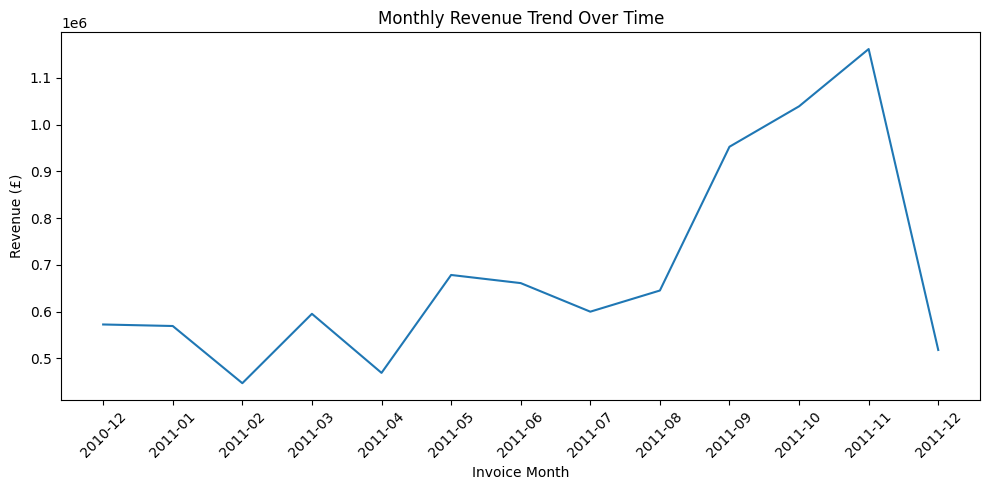

<Figure size 640x480 with 0 Axes>

In [4]:
#revenue over time

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_revenue['InvoiceMonth'].astype(str), monthly_revenue['TotalPrice'])
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend Over Time")
plt.ylabel("Revenue (£)")
plt.xlabel("Invoice Month")
plt.tight_layout()
plt.show()

# Save before showing
plt.savefig("../charts/monthly_revenue.png", dpi=300)
plt.show()

Revenue rose steadily throughout 2011, with notable growth beginning in August and peaking in November, suggesting strong Q4 seasonal performance and holiday sales. The drop in December may reflect incomplete data or post-holiday slowdown.

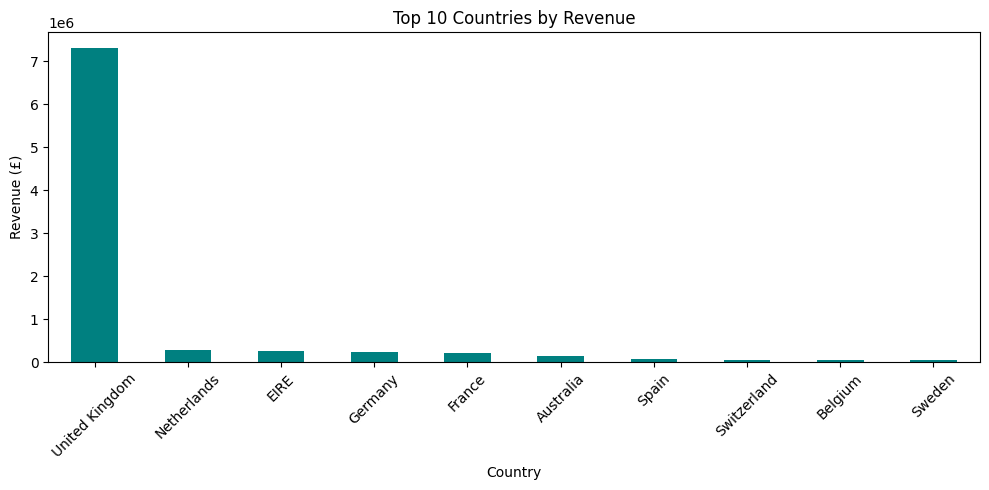

In [22]:
top_countries = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
top_countries.plot(kind='bar', color='teal')
plt.title("Top 10 Countries by Revenue")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../charts/top_countries_revenue.png", dpi=300)
plt.show()

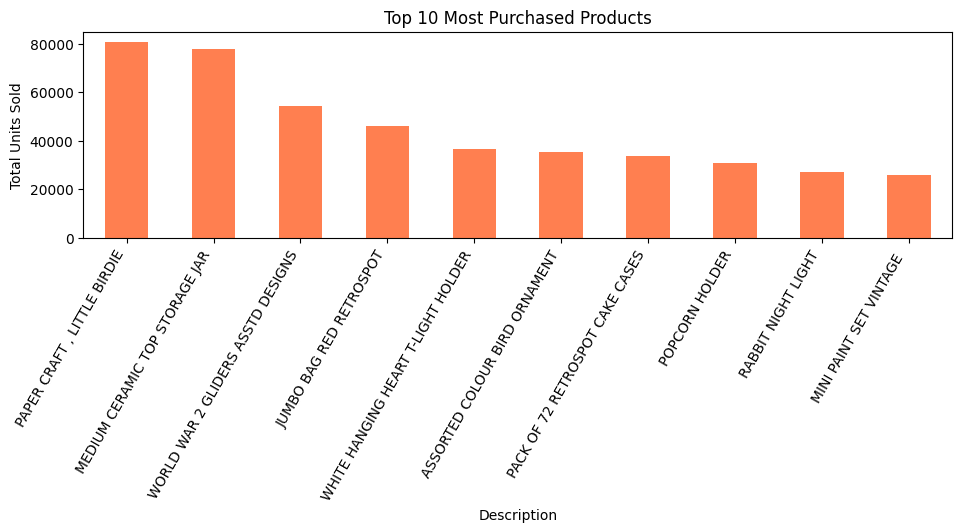

In [25]:
top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 5))
top_products.plot(kind='bar', color='coral')
plt.title("Top 10 Most Purchased Products")
plt.ylabel("Total Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.xticks(rotation=60, ha='right')  # rotate and align labels right
plt.savefig("../charts/top_products.png", dpi=300)
plt.show()

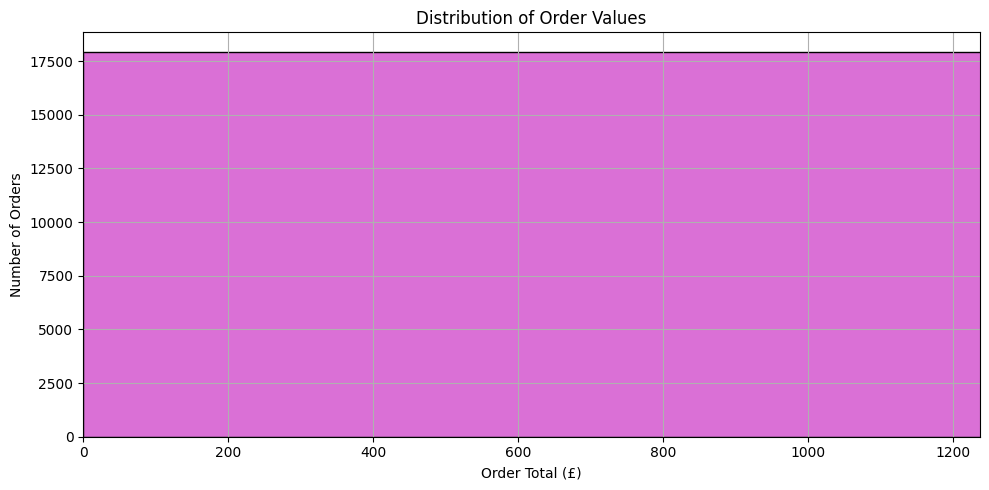

In [24]:
# Total order value per invoice
invoice_values = df.groupby("InvoiceNo")["TotalPrice"].sum()

plt.figure(figsize=(10, 5))
plt.hist(invoice_values, bins=100, color='orchid', edgecolor='black')
plt.title("Distribution of Order Values")
plt.xlabel("Order Total (£)")
plt.ylabel("Number of Orders")
plt.xlim(0, invoice_values.quantile(0.95))  # focus on bulk
plt.grid(True)
plt.tight_layout()
plt.savefig("../charts/order_value_distribution.png", dpi=300)
plt.show()

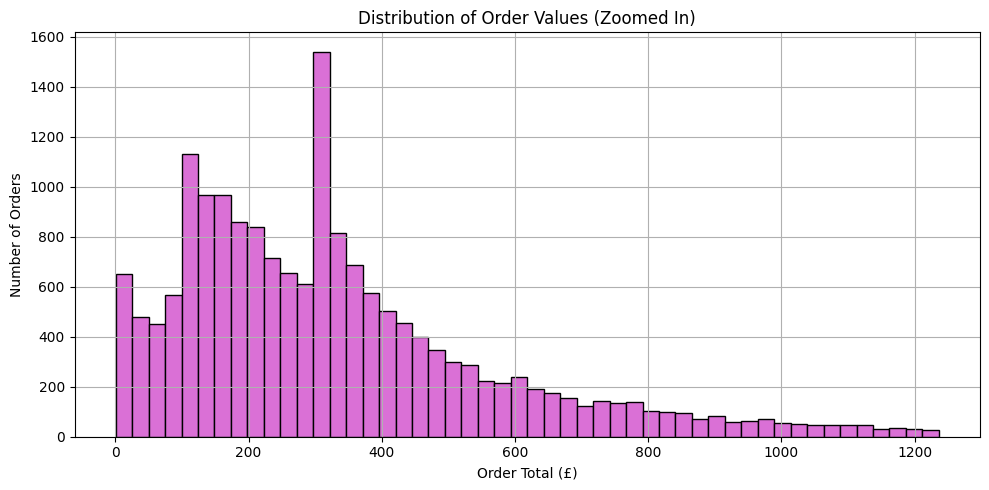

In [26]:
# Show only orders below the 95th percentile
upper_limit = invoice_values.quantile(0.95)

plt.figure(figsize=(10, 5))
plt.hist(invoice_values[invoice_values <= upper_limit], bins=50, color='orchid', edgecolor='black')
plt.title("Distribution of Order Values (Zoomed In)")
plt.xlabel("Order Total (£)")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.tight_layout()
plt.savefig("../charts/order_value_distribution_zoomed.png", dpi=300)
plt.show()

The distribution of order values shows that the majority of invoices fall between £100 and £400, with a strong spike around £300 — possibly due to bundled purchases or standard bulk orders. A long tail of higher-value orders suggests a small number of customers contribute disproportionately through large or recurring purchases.

-The chart skews right, which is typical for B2B businesses

## COHORT ANALYSIS

In [8]:
#Step 1. Assigning first purchase month
# month of each invoice
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# finding the first month each customer made a purchase
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [10]:
#calculating the cohort index e.g. how many month since the customers first purchase : here, 0 meaning making the purchase the same month
#they joined, 1 meaning after one month, 2 after two months and so on
def get_month_diff(df):
    return (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 + \
           (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month)

df['CohortIndex'] = get_month_diff(df)


In [11]:
#building retention table
#create a pivot table with cohort month, cohort index and values with unique customers
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_size = cohort_pivot.iloc[:, 0]  # Month 0 = total customers that month
retention = cohort_pivot.divide(cohort_size, axis=0)

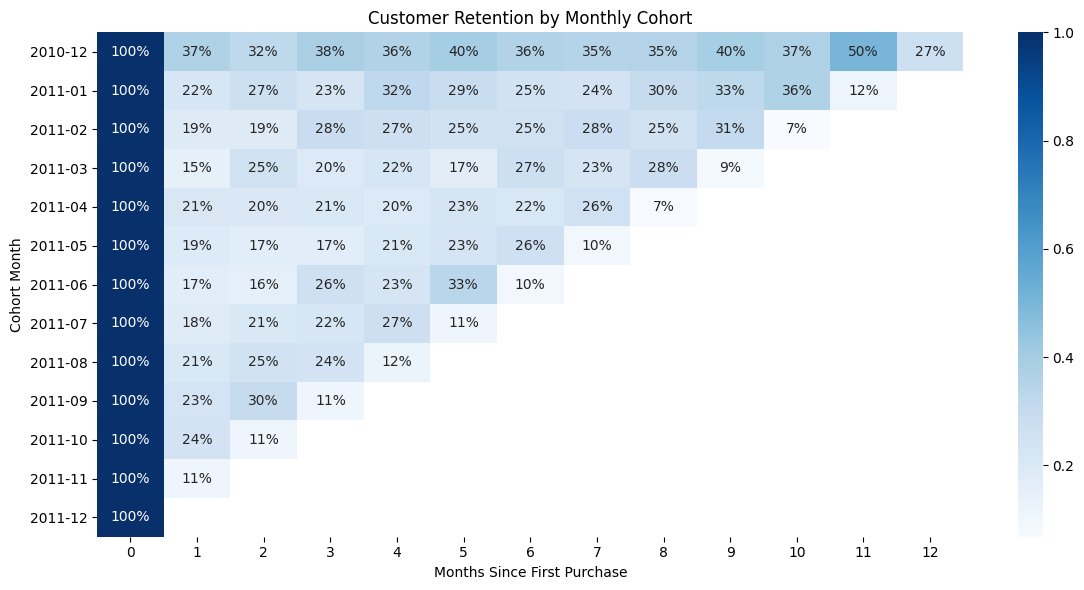

<Figure size 640x480 with 0 Axes>

In [14]:
#Visualizing retention heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title("Customer Retention by Monthly Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.tight_layout()
plt.show()

# Save before showing
plt.savefig("../charts/cohort_retention_heatmap.png", dpi=300)
plt.show()

## Cusromer Lifetime Value (CLV)

In [13]:
#since the data consists of a year-long retail data, we calculate the historic CLV and not the predicted future value
#hence, total revenue per customer
# Group by CustomerID and aggregate total revenue and number of orders
clv_df = df.groupby("CustomerID").agg({
    "TotalPrice": "sum",
    "InvoiceNo": "nunique"  # Number of unique purchases
}).rename(columns={"TotalPrice": "CLV", "InvoiceNo": "NumOrders"})

# Optional: average order value per customer
clv_df["AvgOrderValue"] = clv_df["CLV"] / clv_df["NumOrders"]

# Sort to see top customers
clv_df = clv_df.sort_values("CLV", ascending=False)

clv_df.head()

,CLV,NumOrders,AvgOrderValue
CustomerID,,,
14646.0,280206.02,73,3838.438630
18102.0,259657.30,60,4327.621667
17450.0,194550.79,46,4229.365000
16446.0,168472.50,2,84236.250000
14911.0,143825.06,201,715.547562


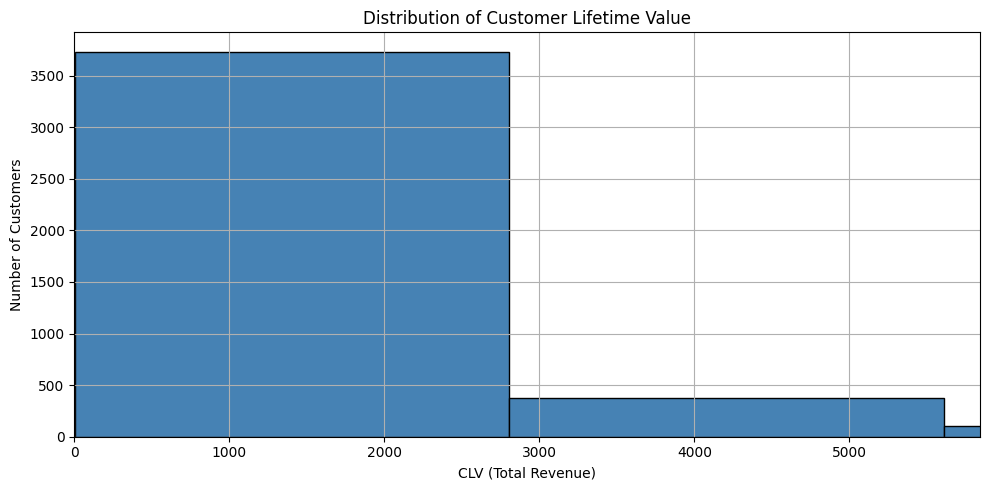

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(clv_df["CLV"], bins=100, color='steelblue', edgecolor='black')
plt.title("Distribution of Customer Lifetime Value")
plt.xlabel("CLV (Total Revenue)")
plt.ylabel("Number of Customers")
plt.xlim(0, clv_df["CLV"].quantile(0.95))  # Zoom in to remove extreme outliers
plt.grid(True)
plt.tight_layout()
plt.savefig("../charts/clv_distribution.png")
plt.show()

#How much money do most customers bring in during the year?

The CLV distribution shows a strong long tail — the majority of customers generate less than £2,500 in revenue, while a small group of high-value customers contribute disproportionately to overall revenue. This supports the Pareto principle and suggests that targeted loyalty strategies for top-tier customers could yield strong returns.

In [19]:
#top 10 customers by CLV
top_10_customers = clv_df.sort_values("CLV", ascending=False).head(10)
top_10_customers

,CLV,NumOrders,AvgOrderValue
CustomerID,,,
14646.0,280206.02,73,3838.438630
18102.0,259657.30,60,4327.621667
17450.0,194550.79,46,4229.365000
16446.0,168472.50,2,84236.250000
14911.0,143825.06,201,715.547562
12415.0,124914.53,21,5948.310952
14156.0,117379.63,55,2134.175091
17511.0,91062.38,31,2937.496129
16029.0,81024.84,63,1286.108571


In [20]:
#segmenting customers by CLV
# Percentile thresholds
low_thresh = clv_df["CLV"].quantile(0.50)
high_thresh = clv_df["CLV"].quantile(0.90)

def segment_clv(row):
    if row["CLV"] <= low_thresh:
        return "Low"
    elif row["CLV"] <= high_thresh:
        return "Medium"
    else:
        return "High"

clv_df["CLV_Segment"] = clv_df.apply(segment_clv, axis=1)
clv_df["CLV_Segment"].value_counts()

CLV_Segment
Low       2169
Medium    1735
High       434
Name: count, dtype: int64

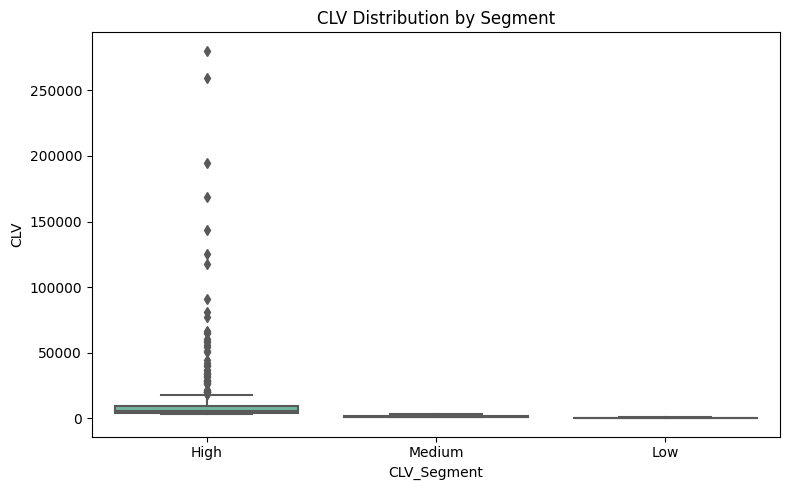

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=clv_df, x="CLV_Segment", y="CLV", palette="Set2")
plt.title("CLV Distribution by Segment")
plt.tight_layout()
plt.savefig("../charts/clv_segments_boxplot.png")
plt.show()

Customers were segmented into Low, Medium, and High CLV groups. While Low CLV customers made up the majority, the High CLV segment — representing only 10% of the customer base — contributed a disproportionately large share of revenue. This supports prioritizing personalized marketing and retention efforts for the high-value group.

## RFM

In [27]:
import datetime

# Reference point: one day after last invoice
reference_date = df["InvoiceDate"].max() + datetime.timedelta(days=1)

In [28]:
#calculate rfm

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                                     # Frequency
    "TotalPrice": "sum"                                         # Monetary
}).rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
})

In [29]:
#Score each metric from 1-4 quartiles
# Higher recency = worse, so we reverse the scoring (lower days = higher score)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])


In [30]:
#conbine into rfm segment
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
rfm["RFM_Score"] = rfm[["R_Score", "F_Score", "M_Score"]].astype(int).sum(axis=1)


In [31]:
#rfm score from 3 to 12: worse to best respectively
def rfm_level(score):
    if score >= 9:
        return "Top Customers"
    elif score >= 6:
        return "Loyal"
    else:
        return "At Risk"

rfm["Segment"] = rfm["RFM_Score"].apply(rfm_level)
rfm["Segment"].value_counts()

Segment
Top Customers    1679
Loyal            1368
At Risk          1291
Name: count, dtype: int64

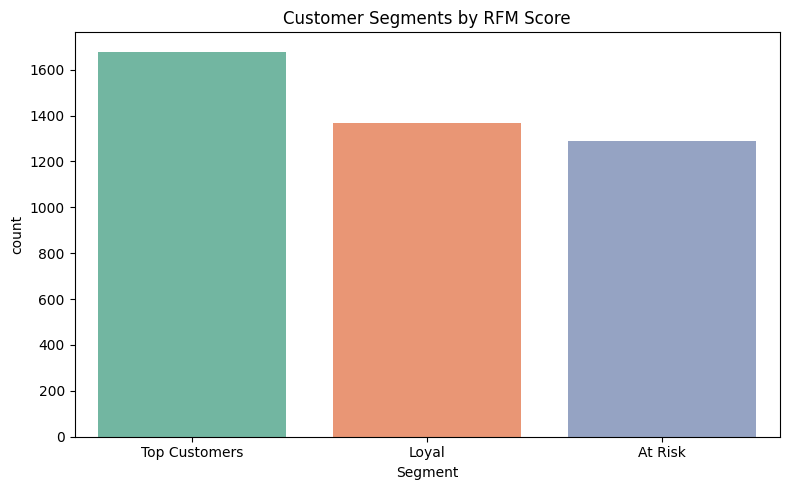

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x="Segment", palette="Set2", order=["Top Customers", "Loyal", "At Risk"])
plt.title("Customer Segments by RFM Score")
plt.tight_layout()
plt.savefig("../charts/rfm_segments.png", dpi=300)
plt.show()

RFM analysis reveals that over one-third of our customers are classified as ‘Top Customers’, showing frequent, recent, and high-value purchasing behavior. An additional substantial segment is made up of ‘Loyal’ customers, who could be converted into top-tier customers with targeted engagement. The ‘At Risk’ segment presents an opportunity for re-engagement campaigns.